# Part 1 : Data manipulation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

import datetime
import gc
from sklearn import preprocessing
from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
import statistics  

import technical_indicators 

from technical_indicators import * # import all function

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

In [2]:
# Set the random seed, number of estimators and the "step factor" used to plot the graph of MSE for each method
random_state = 42  # Seed
n_jobs = -1 # -1 --> all Processors # Parallelisation factor for bagging, random forests (controls the number of processor cores used)
n_estimators = 200 # total number of estimators ot use in the MSE graph
step_factor = 10 # controls cranularity of calculation by stepping through the number of estimators
axis_step = int(n_estimators / step_factor) # 1000/10 = 100 separate calculations will be performed for each of the 3 ensebmle methods

In [3]:
df = pd.read_csv("E:/3eme_ann_ite/projet/AAPL.csv")

In [4]:
display(df.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-30,117.989998,119.410004,117.750000,118.300003,110.548103,39180300
1,2015-12-01,118.750000,118.809998,116.860001,117.339996,109.650993,34852400
2,2015-12-02,117.339996,118.110001,116.080002,116.279999,108.660454,33386600
3,2015-12-03,116.550003,116.790001,114.220001,115.199997,107.651230,41569500
4,2015-12-04,115.290001,119.250000,115.110001,119.029999,111.230263,57777000


In [5]:
#understanding data$
print("data shape :",df.shape)
print("***********")
print("Data description")
print(df.describe())
print("***********")
print("Check for NaN and Total of NaN")
print(df.isnull().sum())
print("***********")
print("Check missing value")
print(df.isna().sum())
print("***********")
print("Check unique values wihtout NaN")
print(df.nunique())

data shape : (755, 7)
***********
Data description
             Open        High         Low       Close   Adj Close  \
count  755.000000  755.000000  755.000000  755.000000  755.000000   
mean   146.322914  147.539695  145.142901  146.380265  141.194831   
std     38.076270   38.453578   37.674610   38.056255   38.670735   
min     90.000000   91.669998   89.470001   90.339996   85.395096   
25%    109.764999  110.575001  108.930000  109.924999  104.138447   
50%    146.520004  147.449997  145.119995  146.529999  140.921082   
75%    174.084999  175.119995  173.019996  174.269996  169.218795   
max    230.779999  233.470001  229.779999  232.070007  227.839798   

             Volume  
count  7.550000e+02  
mean   3.306901e+07  
std    1.522323e+07  
min    1.147590e+07  
25%    2.330605e+07  
50%    2.879210e+07  
75%    3.816835e+07  
max    1.333697e+08  
***********
Check for NaN and Total of NaN
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close  

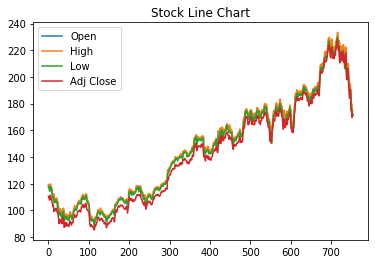

In [6]:
# we see that price has shown a high degree of variability
X = df[['Open','High','Low','Adj Close']]
Y = df.index
plt.plot(X)
plt.title('Stock Line Chart')
plt.legend(X)
plt.show()

In [7]:
df_features = df.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'Open','High', 'Low', 'Close','Volume'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head() # sanity check

,Date,Open,High,Low,Close,Volume
0,2015-11-30,117.989998,119.410004,117.750000,110.548103,39180300
1,2015-12-01,118.750000,118.809998,116.860001,109.650993,34852400
2,2015-12-02,117.339996,118.110001,116.080002,108.660454,33386600
3,2015-12-03,116.550003,116.790001,114.220001,107.651230,41569500
4,2015-12-04,115.290001,119.250000,115.110001,111.230263,57777000


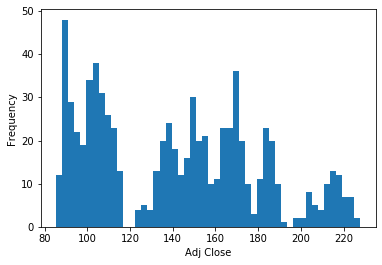

In [8]:
plt.hist(df['Adj Close'], bins = 50)
plt.xlabel("Adj Close")
plt.ylabel("Frequency")
plt.show()

In [9]:
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [10]:
### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
df_features.head(7)

,Date,Open,High,Low,Close,Volume,Today,lag1,lag2,lag3,lag4,lag5
0,2015-11-30,117.989998,119.410004,117.750000,110.548103,39180300,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-01,118.750000,118.809998,116.860001,109.650993,34852400,-0.811511,NaN,NaN,NaN,NaN,NaN
2,2015-12-02,117.339996,118.110001,116.080002,108.660454,33386600,-0.903356,-0.811511,NaN,NaN,NaN,NaN
3,2015-12-03,116.550003,116.790001,114.220001,107.651230,41569500,-0.928787,-0.903356,-0.811511,NaN,NaN,NaN
4,2015-12-04,115.290001,119.250000,115.110001,111.230263,57777000,3.324656,-0.928787,-0.903356,-0.811511,NaN,NaN
5,2015-12-07,118.980003,119.860001,117.809998,110.529411,32084200,-0.630091,3.324656,-0.928787,-0.903356,-0.811511,NaN
6,2015-12-08,117.519997,118.599998,116.860001,110.482658,34309500,-0.042299,-0.630091,3.324656,-0.928787,-0.903356,-0.811511


In [11]:
#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

In [12]:
#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
#drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)



###########################################################################################
# Store Variables now for plots later
daily_index = df_features.index
daily_returns = df_features["Today"]
daily_price   = df_features["Close"]

# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)

,Open,High,Low,Close,Volume,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,95.419998,96.040001,94.279999,88.288963,37357200,-2.022174,-0.934862,3.454137,0.717177,-6.570646,...,0.285714,-8.179307e+06,6.041139e+07,-8.846818e-09,-1.017277,94.955625,97.922768,91.988483,-0.706062,13.000000
2016-02-03,95.000000,96.839996,94.080002,90.036423,45964300,1.979251,-2.022174,-0.934862,3.454137,0.717177,...,0.357143,-4.361714e+05,1.601147e+07,-5.246120e-09,-0.542805,94.752248,97.638676,91.865820,-0.296578,13.690002
2016-02-04,95.860001,97.330002,95.190002,90.759865,46471700,0.803499,1.979251,-2.022174,-0.934862,3.454137,...,0.428571,-1.628914e+06,3.738488e+07,3.468544e-09,-0.093481,94.610847,97.311560,91.910134,-0.310488,14.069999
2016-02-05,96.519997,96.919998,93.690002,88.335838,46418100,-2.670814,0.803499,1.979251,-2.022174,-0.934862,...,0.428571,7.579286e+05,8.118258e+07,2.033415e-09,-0.749412,94.494431,97.258001,91.730861,-0.023000,14.069999
2016-02-08,93.129997,95.699997,93.040001,89.266014,54021400,1.053000,-2.670814,0.803499,1.979251,-2.022174,...,0.357143,8.408579e+06,-9.898051e+05,-3.543767e-09,-0.806576,94.340382,97.068951,91.611812,0.037433,15.279999
2016-02-09,94.290001,95.940002,93.930000,89.247223,44331200,-0.021051,1.053000,-2.670814,0.803499,1.979251,...,0.428571,7.532143e+04,3.361378e+07,4.268104e-09,-0.586151,94.270373,96.801800,91.738947,-0.225124,13.610001
2016-02-10,95.919998,96.349998,94.099998,88.570732,42343600,-0.757997,-0.021051,1.053000,-2.670814,0.803499,...,0.357143,7.766000e+05,1.393129e+07,2.933083e-09,-0.551438,94.180160,96.662301,91.698018,-0.208222,12.430000
2016-02-11,93.790001,94.720001,92.589996,88.035179,50074700,-0.604661,-0.757997,-0.021051,1.053000,-2.670814,...,0.285714,-7.500200e+06,1.059765e+08,-1.359388e-08,-1.037070,93.721611,96.135182,91.308041,-0.209387,12.430000
2016-02-12,94.190002,94.500000,93.010002,88.307655,40351400,0.309508,-0.604661,-0.757997,-0.021051,1.053000,...,0.357143,-9.183500e+05,5.282482e+07,-1.478587e-08,-0.912398,93.296699,95.650984,90.942415,-0.290369,8.950005


### standerize data

In [13]:
df_features['FutureReturns'] = df_features['Today'].shift(-1)
df_features.dropna(inplace=True)

In [14]:
### Standardize Data
##########################################################################################
# Drop Columns
list_of_columns_to_exclude = ["High", "Low", "Open", "Volume","Close", "FutureReturns"]
X_temp_standardized = df_features.copy(deep=True)
X_temp_standardized.drop(list_of_columns_to_exclude, axis = 1, inplace = True) # drop columns

# Standardize
X_temp_standardized
dates = X_temp_standardized.index # get dates to set as index after data is standardized
names = X_temp_standardized.columns # Get column names first
X_temp_standardized = StandardScaler().fit_transform(X_temp_standardized)

# Convert to DataFrame
X_temp_standardized = pd.DataFrame(X_temp_standardized, columns=names, index=dates)
X = X_temp_standardized


### Get y
##########################################################################################
y_temp = pd.DataFrame(df_features["FutureReturns"], index=X.index) # can only standardize a dataframe
sc = StandardScaler()
y = sc.fit_transform(y_temp) # Standardize, cause we did it for our original variables
y = pd.DataFrame(y, index=X.index, columns=["FutureReturns"]) # convert back to dataframe
y = y["FutureReturns"] # now re-get y as a Pandas Series

### Sanity Check
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check Types
print(type(X)) # Needs to be <class 'pandas.core.frame.DataFrame'>
print(type(y)) # Needs ro be <class 'pandas.core.series.Series'>

Shape of X:  (710, 43)
Shape of y:  (710,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [15]:
X_train_all = X.loc[(X.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# # creates all test data which is all after January 2018
X_test = X.loc[(X.index >= '2018-01-01'),:]
y_test = y[X_test.index]

### Sanity Check
print("Shape of X_train_all: ", X_train_all.shape)
print("Shape of y_train_all: ", y_train_all.shape)
print("Shape of X_test:      ", X_test.shape)
print("Shape of y_test:      ", y_test.shape)

Shape of X_train_all:  (483, 43)
Shape of y_train_all:  (483,)
Shape of X_test:       (227, 43)
Shape of y_test:       (227,)
